In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Dataset - sample_transactions.csv

In [6]:
df = pd.read_csv('sample_transactions.csv')
df.head()

,CustomerID,ProductID,Category,PurchaseAmount,PurchaseDate
0,C001,P001,Electronics,15000,2024-01-15
1,C002,P002,Fashion,2500,2024-01-16
2,C003,P003,Groceries,500,2024-01-17
3,C001,P002,Fashion,3000,2024-02-10
4,C004,P004,Electronics,20000,2024-02-12


### Next Steps to do:
- Cleaning the data (handle missing values, data types)
- Doing Feature engineering (RFM analysis, category preferences)
- Apply clustering (K-Means / Hierarchical)
- Visualization results
- Build recommendation logic

### 1. Check for missing values in the data 

In [7]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
CustomerID        0
ProductID         0
Category          0
PurchaseAmount    0
PurchaseDate      0
dtype: int64


### 2. Handle missing values

In [8]:
# - Drop the rows where CustomerID or ProductID is missing.
df.dropna(subset=['CustomerID','ProductID'], inplace=True)

In [9]:
# if PurchaseAmount is Missing , fill it with '0'
df['PurchaseAmount'] = df['PurchaseAmount'].fillna(0)


In [10]:
# if Category is null , fill the null cell with "Unknown"
df['Category'] = df['Category'].fillna('Unknown')
df

,CustomerID,ProductID,Category,PurchaseAmount,PurchaseDate
0,C001,P001,Electronics,15000,2024-01-15
1,C002,P002,Fashion,2500,2024-01-16
2,C003,P003,Groceries,500,2024-01-17
3,C001,P002,Fashion,3000,2024-02-10
4,C004,P004,Electronics,20000,2024-02-12
5,C005,P005,Groceries,700,2024-02-15


### 3. Ensure correct data types

In [11]:
df['CustomerID'] = df['CustomerID'].astype(str)
df['ProductID'] = df['ProductID'].astype(str)
df['Category'] = df['Category'].astype(str)
df['PurchaseAmount'] = df['PurchaseAmount'].astype(float)
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'], errors='coerce')

In [12]:
df = df.dropna(subset=['PurchaseDate'])
print("\nData types after cleaning:")
print(df.dtypes)

print("\nSample of cleaned data:")
df.head()


Data types after cleaning:
CustomerID                object
ProductID                 object
Category                  object
PurchaseAmount           float64
PurchaseDate      datetime64[ns]
dtype: object

Sample of cleaned data:


,CustomerID,ProductID,Category,PurchaseAmount,PurchaseDate
0,C001,P001,Electronics,15000.0,2024-01-15
1,C002,P002,Fashion,2500.0,2024-01-16
2,C003,P003,Groceries,500.0,2024-01-17
3,C001,P002,Fashion,3000.0,2024-02-10
4,C004,P004,Electronics,20000.0,2024-02-12


### Feature Engineering

In [13]:
# Total spent 
total_spent = df.groupby('CustomerID')['PurchaseAmount'].sum().reset_index(name='Total_Spent')
print(total_spent)

  CustomerID  Total_Spent
0       C001      18000.0
1       C002       2500.0
2       C003        500.0
3       C004      20000.0
4       C005        700.0


In [14]:
# Purchase frequency
purchase_count = df.groupby('CustomerID').size().reset_index(name='PurchaseCount')
print(purchase_count)

  CustomerID  PurchaseCount
0       C001              2
1       C002              1
2       C003              1
3       C004              1
4       C005              1


In [15]:
# Average purchase amount
avg_purchase = df.groupby('CustomerID')['PurchaseAmount'].mean().reset_index(name='AvgPurchaseAmount')
print(avg_purchase)

  CustomerID  AvgPurchaseAmount
0       C001             9000.0
1       C002             2500.0
2       C003              500.0
3       C004            20000.0
4       C005              700.0


In [16]:
import datetime as dt

# Recency
latest_date = df.groupby('CustomerID')['PurchaseDate'].max().reset_index()
print(latest_date)
print()
latest_date['RecencyDays'] = (dt.datetime.now() - latest_date['PurchaseDate']).dt.days
print(latest_date['RecencyDays'])

  CustomerID PurchaseDate
0       C001   2024-02-10
1       C002   2024-01-16
2       C003   2024-01-17
3       C004   2024-02-12
4       C005   2024-02-15

0    624
1    649
2    648
3    622
4    619
Name: RecencyDays, dtype: int64


In [17]:
print(latest_date)

  CustomerID PurchaseDate  RecencyDays
0       C001   2024-02-10          624
1       C002   2024-01-16          649
2       C003   2024-01-17          648
3       C004   2024-02-12          622
4       C005   2024-02-15          619


In [18]:
# Preferred category by the Customers 
preferred_category = df.groupby(['CustomerID','Category']).size().reset_index(name='Count')
preferred_category = preferred_category.loc[preferred_category.groupby('CustomerID')['Count'].idxmax()][['CustomerID','Category']]
print(preferred_category)

  CustomerID     Category
0       C001  Electronics
2       C002      Fashion
3       C003    Groceries
4       C004  Electronics
5       C005    Groceries


In [19]:
# Merge all the features 
customer_profiles = total_spent.merge(purchase_count, on='CustomerID') \
                               .merge(avg_purchase, on='CustomerID') \
                               .merge(latest_date[['CustomerID','RecencyDays']], on='CustomerID') \
                               .merge(preferred_category, on='CustomerID')

customer_profiles

,CustomerID,Total_Spent,PurchaseCount,AvgPurchaseAmount,RecencyDays,Category
0,C001,18000.0,2,9000.0,624,Electronics
1,C002,2500.0,1,2500.0,649,Fashion
2,C003,500.0,1,500.0,648,Groceries
3,C004,20000.0,1,20000.0,622,Electronics
4,C005,700.0,1,700.0,619,Groceries


### Customer Segmentation

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['Total_Spent','PurchaseCount','AvgPurchaseAmount','RecencyDays']
X = customer_profiles[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(X_scaled)

customer_profiles

,CustomerID,Total_Spent,PurchaseCount,AvgPurchaseAmount,RecencyDays,Category,Cluster
0,C001,18000.0,2,9000.0,624,Electronics,2
1,C002,2500.0,1,2500.0,649,Fashion,0
2,C003,500.0,1,500.0,648,Groceries,0
3,C004,20000.0,1,20000.0,622,Electronics,1
4,C005,700.0,1,700.0,619,Groceries,0


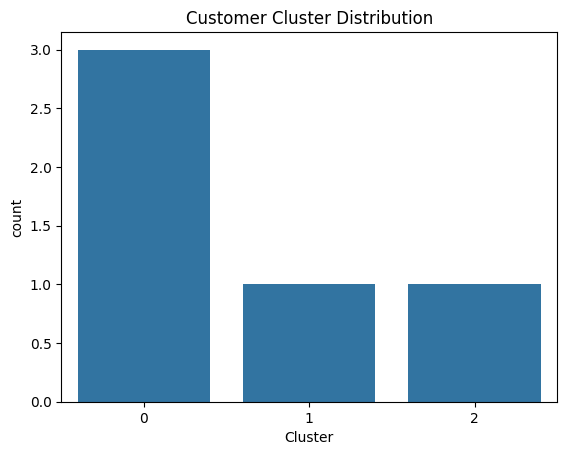

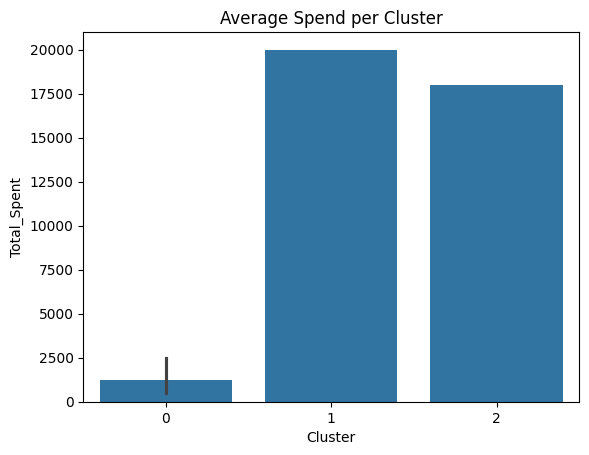

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Cluster', data=customer_profiles)
plt.title("Customer Cluster Distribution")
plt.show()

sns.barplot(x='Cluster', y='Total_Spent', data=customer_profiles)
plt.title("Average Spend per Cluster")
plt.show()

###Recommendations based on Total Amount, Total Freq, Hybrid of Amount & Freq

In [22]:
df_clustered = df.merge(customer_profiles[['CustomerID','Cluster']], on='CustomerID')
top_category_per_cluster = df_clustered.groupby(['Cluster','Category'])['PurchaseAmount'] \
                                      .sum().reset_index() \
                                      .sort_values(['Cluster','PurchaseAmount'], ascending=[True,False])

print("Recommendation by Total Amount")
print()
print(top_category_per_cluster)

Recommendation by Total Amount

   Cluster     Category  PurchaseAmount
0        0      Fashion          2500.0
1        0    Groceries          1200.0
2        1  Electronics         20000.0
3        2  Electronics         15000.0
4        2      Fashion          3000.0


In [23]:
# Recommend by purchase frequency..
top_category_by_frequency = df_clustered.groupby(['Cluster','Category'])['ProductID'] \
                                       .count().reset_index(name='PurchaseCount') \
                                       .sort_values(['Cluster','PurchaseCount'], ascending=[True,False])
print("Recommended by Frequency:")
top_category_by_frequency

Recommended by Frequency:


,Cluster,Category,PurchaseCount
1,0,Groceries,2
0,0,Fashion,1
2,1,Electronics,1
3,2,Electronics,1
4,2,Fashion,1


In [24]:
# Combine amount and frequency
category_scores = df_clustered.groupby(['Cluster','Category']).agg({
    'PurchaseAmount': ['sum', 'mean'],
    'ProductID': 'count'
}).reset_index()

category_scores.columns = ['Cluster','Category','TotalSpend','AvgSpend','PurchaseCount']
category_scores['Score'] = category_scores['TotalSpend'] * 0.5 + category_scores['PurchaseCount'] * 0.5
top_hybrid = category_scores.sort_values(['Cluster','Score'], ascending=[True,False])
print("Recommended by Hybrid Score:")
top_hybrid[['Cluster','Category','Score']]

Recommended by Hybrid Score:


,Cluster,Category,Score
0,0,Fashion,1250.5
1,0,Groceries,601.0
2,1,Electronics,10000.5
3,2,Electronics,7500.5
4,2,Fashion,1500.5
